## Neuro-Comp

In [1]:
# import dependencies
import configparser
import cv2 as cv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from IPython.display import Image
import pathlib
import PIL
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import shutil
import snntoolbox.bin.run as snn
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import utils

In [2]:
# read compressed dataset
data_path = pathlib.Path(r'../datasets/ck_plus_48.npz')
with np.load(data_path) as data:
    images = data['images']
    labels = data['labels']
    classes = data['classes']
print(f"Found {images.shape[0]} examples in {labels.shape[1]} classes.")
print(f"Shape= {(images.shape[1], images.shape[2])}")
print(f"Class Names= {classes}")

Found 981 examples in 7 classes.
Shape= (48, 48)
Class Names= ['happy' 'contempt' 'fear' 'surprise' 'sadness' 'anger' 'disgust']


In [3]:
# constants
CLASS_LABELS = classes
NUM_CLASSES = len(classes)
BATCH_SIZE = 24
IMAGE_DIMS = (48, 48)
SEED = 123
_TRAIN = .7
_VAL = .15
_TEST = .15

# create a dataset object and shuffle
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(len(images) * BATCH_SIZE, seed=SEED)
shuffle_images = []
shuffle_labels = []
for im, l in dataset.as_numpy_iterator():
    shuffle_images.append(im)
    shuffle_labels.append(l)
shuffle_images = np.asarray(shuffle_images)
shuffle_labels = np.asarray(shuffle_labels)

# create the slicing indices
TRAIN = round(len(dataset) * _TRAIN)
VAL = TRAIN + round(len(dataset) * _VAL)
TEST = VAL + round(len(dataset) * _TEST)

train_ds = utils.data_pipeline(
    shuffle_images[0:TRAIN], shuffle_labels[0:TRAIN], IMAGE_DIMS,
    edges=False, batch_size=BATCH_SIZE, flip=True)
val_ds = utils.data_pipeline(
    shuffle_images[TRAIN:VAL], shuffle_labels[TRAIN:VAL], IMAGE_DIMS,
    edges=False, batch_size=BATCH_SIZE, flip=True)
test_ds = utils.data_pipeline(
    shuffle_images[VAL:TEST], shuffle_labels[VAL:TEST], IMAGE_DIMS,
    edges=False, batch_size=BATCH_SIZE, shuffle=True)

print(f"Using {len(train_ds)*BATCH_SIZE} samples for training.")
print(f"Using {len(val_ds)*BATCH_SIZE} samples for validation.")
print(f"Using {len(test_ds)*BATCH_SIZE} samples for testing.")

# benchmark the datasets
## tfds.benchmark(train_ds, batch_size=BATCH_SIZE)
## tfds.benchmark(val_ds, batch_size=BATCH_SIZE)
## tfds.benchmark(test_ds, batch_size=BATCH_SIZE)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Using 672 samples for training.
Using 144 samples for validation.
Using 144 samples for testing.


2022-06-20 13:59:41.478517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-20 13:59:41.478641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Max= 0.8274509906768799  Min= 0.0
Max= 1.0  Min= 0.03529411926865578
Max= 1.0  Min= 0.0
Max= 1.0  Min= 0.0
Max= 1.0  Min= 0.019607843831181526
Max= 1.0  Min= 0.019607843831181526


2022-06-20 13:59:41.716837: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


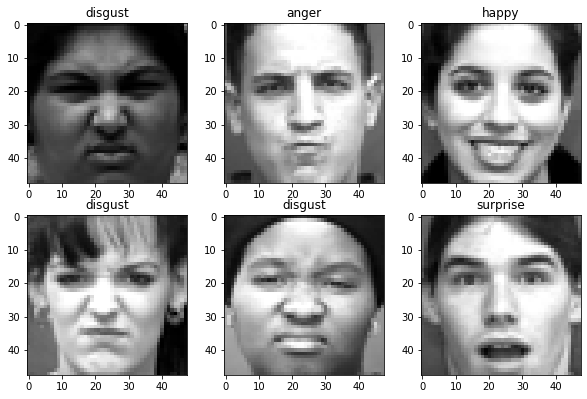

In [4]:
# make plt figure
plt.figure(figsize=(10, 10))

# get a sample batch
for im, l in train_ds.take(1):
    # get first 6 images in batch
    for i in range(6):
        arr = im.numpy()[i, :, :, :]

        # get max/min
        print(f"Max= {np.max(arr)}  Min= {np.min(arr)}")

        # show the image
        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"{CLASS_LABELS[np.argmax(l[i])]}")
        plt.imshow(arr, cmap='gray')

In [5]:
# construct the model
k_size = (8, 8)
p_size = (4, 4)
stride = (2, 2)
model = tf.keras.models.Sequential([

    # Convolutional Block 1
    tf.keras.layers.Conv2D(input_shape=IMAGE_DIMS + (3, ),
        filters=4, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size,strides=stride),

    # Convolutional Block 2
    tf.keras.layers.Conv2D(filters=8, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size,strides=stride),

    # convolutional Block 3
    tf.keras.layers.Conv2D(filters=16, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size,strides=stride),

    # Convolutional Block 4
    tf.keras.layers.Conv2D(filters=32, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size,strides=stride),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32,activation="relu"),
    tf.keras.layers.Dense(units=16,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax")    
  
])


### # display the model summary
model.summary()
### 
### # plot the model architecture
### tf.keras.utils.plot_model(
###     model, to_file='./images/architecture.png', show_shapes=True, show_dtype=False,
###     show_layer_names=True, rankdir='TB', expand_nested=False, dpi=150,
###     layer_range=None, show_layer_activations=False
### )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 4)         772       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 4)        16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 8)         2056      
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 8)        32        
 hNormalization)                                                 
                                                        

In [6]:
# set epochs
NUM_EPOCHS = 100
DECAY_STEPS = (len(train_ds)) * 50
print(f"Decay steps per epoch= {DECAY_STEPS}")

# define learning rate decay
lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.002, decay_steps=DECAY_STEPS, decay_rate=1, staircase=False
)

# plot the learning rate
step = np.linspace(0, NUM_EPOCHS)
lr = lr_decay(step)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step, y=lr,
                    mode='lines',
                    name='lines'))
fig.update_layout(
    template='plotly_dark',
    title={'text': "Learning Rate Decay", 'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Epochs",
    yaxis_title="LR Value",)

# save and display the plot image
fig.write_image("./tests/learning_rate_decay.png", width=1000)
fig.show()

Decay steps per epoch= 1400


In [7]:
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_decay),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# remove old model file and training history
try:
    os.remove('./tests/test_model.h5')
except:
    pass
try:
    os.remove('./tests/test_history.json')
except:
    pass

# add checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './tests/test_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best=True,
    save_weights_only=False,
    mode='max'
)

# add early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=.004,
    patience=10,
    verbose=1,
    mode='auto'
)

# Train the model
history = model.fit(
    train_ds, validation_data=val_ds, epochs=NUM_EPOCHS,
    verbose=2, callbacks=[checkpoint])
json.dump(history.history, open('./tests/test_history.json', 'w'))

Epoch 1/100


2022-06-20 13:59:43.058475: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-20 13:59:43.058668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 - 1s - loss: 1.9909 - accuracy: 0.1429 - val_loss: 1.9527 - val_accuracy: 0.1736 - 1s/epoch - 41ms/step
Epoch 2/100


2022-06-20 13:59:43.781501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 - 1s - loss: 1.7802 - accuracy: 0.2426 - val_loss: 1.9720 - val_accuracy: 0.0903 - 517ms/epoch - 18ms/step
Epoch 3/100
28/28 - 1s - loss: 1.6390 - accuracy: 0.3750 - val_loss: 1.9931 - val_accuracy: 0.0556 - 516ms/epoch - 18ms/step
Epoch 4/100
28/28 - 1s - loss: 1.5150 - accuracy: 0.4673 - val_loss: 2.0159 - val_accuracy: 0.0556 - 532ms/epoch - 19ms/step
Epoch 5/100
28/28 - 0s - loss: 1.4072 - accuracy: 0.5238 - val_loss: 2.0416 - val_accuracy: 0.0556 - 479ms/epoch - 17ms/step
Epoch 6/100
28/28 - 0s - loss: 1.2940 - accuracy: 0.5804 - val_loss: 2.0618 - val_accuracy: 0.0556 - 476ms/epoch - 17ms/step
Epoch 7/100
28/28 - 0s - loss: 1.2009 - accuracy: 0.5967 - val_loss: 2.0673 - val_accuracy: 0.0556 - 477ms/epoch - 17ms/step
Epoch 8/100
28/28 - 0s - loss: 1.0978 - accuracy: 0.6503 - val_loss: 2.0551 - val_accuracy: 0.0556 - 471ms/epoch - 17ms/step
Epoch 9/100
28/28 - 0s - loss: 1.0195 - accuracy: 0.6830 - val_loss: 2.0487 - val_accuracy: 0.0625 - 473ms/epoch - 17ms/step
Epoch 10/100

In [8]:
# plot the results
epochs_range = np.arange(len(history.history['accuracy']))
fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

fig.add_trace(
    go.Scatter(
        x=epochs_range, y=history.history['accuracy'],
        name='Training', legendgroup='accuracy', mode='lines',  line=dict(color='blue'),
        legendgrouptitle_text='Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs_range, y=history.history['val_accuracy'], mode='lines',  line=dict(color='green'),
    name='Validation', legendgroup='accuracy'), row=1, col=1)

fig.add_trace(
    go.Scatter(x=epochs_range, y=history.history['loss'], line=dict(color='blue'),
    mode='lines', showlegend=False), row=1, col=2)
fig.add_trace(
    go.Scatter(x=epochs_range, y=history.history['val_loss'], line=dict(color='green'),
    mode='lines', showlegend=False), row=1, col=2)


fig.update_layout(
    template='plotly_dark',
    title="Test Results",
    title_x=0.5
    ## xaxis_title="Epochs"
    ## yaxis_title="LR Value",)
)

# save and display the plot image
pio.write_image(fig, "./tests/history.png", scale=6, width=1000, height=600)
fig.show()

In [9]:
# store the data for SNN conversion/simulation
x_test = []
y_test = []
x_norm = []

# create the dataset for SNN simulation
for im, l in test_ds.as_numpy_iterator():
    for i in range(np.shape(im)[0]):
        #print(im[i, :, :, :].shape)
        x_test.append(im[i, :, :, :])
        y_test.append(l[i, :])

# create a dataset for normalization
for im, l in list(train_ds.as_numpy_iterator())[:2500]: # 4 for JAFFE, 30+ for FER2013
    for i in range(np.shape(im)[0]):
        #print(im[i, :, :, :].shape)
        x_norm.append(im[i, :, :, :])



x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_norm = np.asarray(x_norm)

np.savez_compressed(r'./tests/x_test', x_test)
np.savez_compressed(r'./tests/y_test', y_test)
np.savez_compressed(r'./tests/x_norm', x_norm)

In [10]:
# evaluate the model
_loss, _acc = model.evaluate(test_ds, verbose=2)

6/6 - 0s - loss: 0.4867 - accuracy: 0.8542 - 46ms/epoch - 8ms/step


In [11]:
# create confusion matrix
y_pred = np.argmax(model.predict(x_test, verbose=2), axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred).numpy()
con_mat_norm = np.around(
    confusion_mtx.astype('float') /
    confusion_mtx.sum(axis=1)[:, np.newaxis],
    decimals=3
)

fig = ff.create_annotated_heatmap(
    con_mat_norm, x=[str(x) for x in CLASS_LABELS], y=[str(x) for x in CLASS_LABELS])#, colorscale='deep')
fig.update_layout(
    template='plotly_dark',
    title={'text': "Confusion Matrix", 'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="Prediction",
    yaxis_title="Actual"
)
fig['data'][0]['showscale'] = True
fig['layout']['yaxis']['autorange'] = "reversed"
fig['layout']['xaxis']['side'] = 'bottom'
pio.write_image(fig, './tests/confusion_matrix.png', width=1000, height=800, scale=6)
fig.show()

5/5 - 0s - 168ms/epoch - 34ms/step


2022-06-20 14:00:33.401358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Initializing INI simulator...

Loading data set from '.npz' files in /Users/heathsmith/repos/github/neuromorphic-computing/neurocomp/tests.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 4)         772       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 4)        16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 8)         2056      
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 8)

2022-06-20 14:00:34.436973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Writing activations to disk...
Scale factor: 9.98.
Calculating activations of layer 02Conv2D_23x23x8 ...
28/28 [==============================] - 0s 3ms/step
Writing activations to disk...


2022-06-20 14:00:35.661059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Scale factor: 2.72.
Calculating activations of layer 04Conv2D_10x10x16 ...
28/28 [==============================] - 0s 3ms/step


2022-06-20 14:00:36.078813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Writing activations to disk...
Scale factor: 1.04.
Calculating activations of layer 06Conv2D_4x4x32 ...
28/28 [==============================] - 0s 3ms/step


2022-06-20 14:00:36.284316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:36.473077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Writing activations to disk...
Scale factor: 0.27.
Calculating activations of layer 09Dense_32 ...
28/28 [==============================] - 0s 3ms/step
Writing activations to disk...
Scale factor: 0.01.
Calculating activations of layer 10Dense_16 ...
22/28 [======================>.......] - ETA: 0s

2022-06-20 14:00:36.641159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 6ms/step
Writing activations to disk...
Scale factor: 0.04.
Calculating activations of layer 11Dense_7 ...
28/28 [==============================] - 0s 4ms/step


2022-06-20 14:00:37.031258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Writing activations to disk...
Scale factor: 0.16.
Using scale factor 1.00 for softmax layer.

Building spiking model...
Building layer: 00Conv2D_48x48x4


2022-06-20 14:00:38.095177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 01MaxPooling2D_23x23x4
Building layer: 02Conv2D_23x23x8
Building layer: 03MaxPooling2D_10x10x8


2022-06-20 14:00:38.568333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:38.665479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 04Conv2D_10x10x16


2022-06-20 14:00:38.774200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:38.873775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 05MaxPooling2D_4x4x16
Building layer: 06Conv2D_4x4x32


2022-06-20 14:00:38.989179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:39.095965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 07MaxPooling2D_1x1x32
Building layer: 08Flatten_32
Building layer: 09Dense_32


2022-06-20 14:00:39.193114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:39.346486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 10Dense_16


2022-06-20 14:00:39.453446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Building layer: 11Dense_7
Compiling spiking model...

Detected layer with biases: 00Conv2D_48x48x4
Detected layer with biases: 02Conv2D_23x23x8
Detected layer with biases: 04Conv2D_10x10x16
Detected layer with biases: 06Conv2D_4x4x32
Detected layer with biases: 09Dense_32
Detected layer with biases: 10Dense_16
Detected layer with biases: 11Dense_7
Number of operations of ANN: 8411615
Number of neurons: 18819
Number of synapses: 4213560

Saving model to ./tests/test_model_INI.h5...


Starting new simulation...

Current accuracy of batch:


2022-06-20 14:00:39.753733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:39.899881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20.83%
Batch 1 of 6 completed (16.7%)
Moving accuracy of SNN (top-1, top-1): 20.83%, 20.83%.
Moving accuracy of ANN (top-1, top-1): 20.83%, 20.83%.



2022-06-20 14:00:46.090869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-06-20 14:00:46.296747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.319882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.343021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.362846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.382162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.403300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.440286: I tensorflow/core/grappler/optimizers/cust


Starting new simulation...

Current accuracy of batch:
 16.67%

2022-06-20 14:00:46.514517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.579736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 14:00:46.628244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 16.67%
Batch 2 of 6 completed (33.3%)
Moving accuracy of SNN (top-1, top-1): 18.75%, 18.75%.
Moving accuracy of ANN (top-1, top-1): 18.75%, 18.75%.


Starting new simulation...

Current accuracy of batch:
 29.17%
Batch 3 of 6 completed (50.0%)
Moving accuracy of SNN (top-1, top-1): 22.22%, 22.22%.
Moving accuracy of ANN (top-1, top-1): 22.22%, 22.22%.


Starting new simulation...

Current accuracy of batch:
 45.83%
Batch 4 of 6 completed (66.7%)
Moving accuracy of SNN (top-1, top-1): 28.12%, 28.12%.
Moving accuracy of ANN (top-1, top-1): 28.13%, 28.13%.


Starting new simulation...

Current accuracy of batch:
 29.17%
Batch 5 of 6 completed (83.3%)
Moving accuracy of SNN (top-1, top-1): 28.33%, 28.33%.
Moving accuracy of ANN (top-1, top-1): 28.33%, 28.33%.


Starting new simulation...

Current accuracy of batch:
 16.67%
Batch 6 of 6 completed (100.0%)
Moving accuracy of SNN (top-1, top-1): 26.39%, 26.39%.
Moving accuracy of ANN (top-1, top-1): 26.39%, 26.39%.

Simulation finished.


To

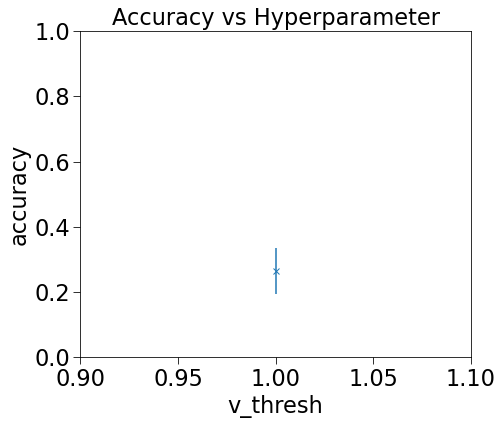

In [12]:
try:
    os.remove('./tests/test_model_parsed.h5')
except:
    pass
try:
    os.remove('./tests/test_model_INI.h5')
except:
    pass
try:
    shutil.rmtree('./tests/test_snn')
except:
    pass

# run snn conversion/simulation
snn.main("./tests/config.ini")

In [13]:
## fig = go.Figure(data=[go.Table(
##     header=dict(values=['Dataset', 'CNN Accuracy', 'CNN Loss', 'SNN Accuracy'],
##                 line_color='darkslategray',
##                 fill_color='lightskyblue',
##                 align='left'),
##     cells=dict(values=[["CK+", "JAFFE", "FER-2013"], # 1st column
##                        ["95.31%", "75.00%", "50.03%"], # 2nd column
##                         ["0.2108", "0.9501", "1.309"],
##                         ["42.50%", "30.00%", "31.64%"]], # 4th column
##                line_color='darkslategray',
##                fill_color='lightcyan',
##                align='left'))
## ])
## 
## fig.update_layout(width=600, height=600,)
## pio.write_image(fig, './tests/accuracies.png', width=500, height=300, scale=2)
## fig.show()